# Episode 04: Proof of concepts

TODO

**Goals for this episode:**
- Try to solve the puzzle with the board defined in Episode 01
- List potential strategies or heuristics

Now we have a board, we can test some ways to solve the puzzle.

Lets's say that the solution is known.

I can ilplement a trial and error process.

# 1. TODO

In [6]:
from episode04 import clues2x2, solution2x2, clues5x5s, solution5x5s
from episode04 import Puzzle, Board, BoardMark, GameEngine

import numpy as np

# 2. Try-and-error process

Having an idea from scratch is difficult.

The contract with the platyer for Nonograms is that they always have 1 solution. Let's say we know that there is a solution. We can try different values for each cell until the board is solved.

Even if this process is probably not what we want, it will help undestand what we need to solve the puzzle. 

In addition, it make sense in AI. Some algorithms, especially in Reinforcement Learning, work by learning from try-and-error process. They are given the goal to keep errors to a minimulm.

What could be the try-and-error process ?

For each cell, I know that it could be black or filler. 

We need some game engine to decide whether the action is valid or not according to be solution it knows already. 

Now, let's loop over the problem space

## 2.2. Experiments

In [ ]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

for row in range(board2x2.height):
    for col in range(board2x2.width):
        if game2x2.is_action_valid(row, col, BoardMark.BLACK):
            board2x2.mark(row, col, BoardMark.BLACK)
        else: 
            board2x2.mark(row, col, BoardMark.FILLER)

game2x2.show_board()
print(f"error_count:{game2x2.errors}")

Voila!

I agree that this algorithm is pretty dump. The percentage of errors goes up very rapidly and exceed what the game will accept (usually 3 errors). On the 5x5 board it took 11 errors to solve 25 cells.

In [ ]:
# create the game engine
puzzle5x5s = Puzzle(clues5x5s)
game5x5s = GameEngine(puzzle5x5s, solution5x5s)
board5x5s = game5x5s.board

for row in range(board5x5s.height):
    for col in range(board5x5s.width):
        if game5x5s.is_action_valid(row, col, BoardMark.BLACK):
            board5x5s.mark(row, col, BoardMark.BLACK)
        else: 
            board5x5s.mark(row, col, BoardMark.FILLER)

game5x5s.show_board()
print(f"error_count:{game5x5s.errors}")

# 2.3  Wrap up

What works:
- it is really simple to design and implement
- no computation, no headache with split blocks

Limitation:
- requires that the solution is known beforehand
- roughly 50% error rate. It depends on the proportion of blacks and fillers,  and whether blacks or fillers are checked for validity

# 3. Brute Force

The idea behind brute force is to generate all possible options and then check which one is vaid.

Unlike try-and-error the validation will take place on the whole board. We do not need to know the solution beforehand. The engine can compute the clues from the board and check whether the board holds or breaks the clues.

## 3.1. Experiment on 2x2

The first steo is to list all possible options for the oard.

The board is a list of 0 and 1. From the clues we know the number of black cells. It is the sum of all clues.

All possible boards are permutations of this black cells over the cells of the board. If I have [1,0] all permutations are [1,0] and [0,1]

In [ ]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

In [ ]:
from itertools import repeat, chain, tee
# 3 blacks
black_iterator = repeat(BoardMark.BLACK.value, puzzle2x2.required_blacks_count) 
# 1 filler
fillers_count = puzzle2x2.cells_count - puzzle2x2.required_blacks_count
filler_iterator = repeat(BoardMark.FILLER.value, fillers_count) 
# chain concatenate both iterators
# tee -is used for debugging, it duplicates the iterator which can be consummed only once
initial_states_iterator, debug_iterator = tee(chain(black_iterator, filler_iterator))
# show the value for debugging
list(debug_iterator)

In [ ]:
from itertools import permutations
# generate permutations 
permutations_iterator, debug_iterator = tee(permutations(initial_states_iterator))
list(debug_iterator)
# there are 16 because permutation switch elements of the list and not values
# it does not take care that 1 occurs many times

In [ ]:
import numpy as np

# set avoids duplicates generated by permutations
for o in set(permutations_iterator):
    print(f"option:{o}")
    # select valid options
    if game5x5s: # option is a tuple () not a lust
        print(f"valid:{o}")
        board2x2.fill_all(o)

In [ ]:
game2x2.show_board()

## 3.2. Experiment on 2x2 - Alternative implementation

Another way of analysing this problem is to get all possible indexs of black cells instead of all possible boards.

Let's say there is a jar with numbers from 0 to 3. These are possible positions of a cell in the board. I want to draw 3 numbers from the jar. This is named combination.

In [ ]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

In [ ]:
from itertools import combinations, tee
# want to get 3 positions in a range 0 - 4 where 4 is the number of cells
# we want each position to be unique thus no replacement
values = range(puzzle2x2.cells_count)
nb_drawn = puzzle2x2.required_blacks_count
temp_combinations_iterator = combinations(values, nb_drawn) 
combinations_iterator, debug_iterator = tee(temp_combinations_iterator)
list(debug_iterator)

In [ ]:
import numpy as np

for option in combinations_iterator:
    print(f"option:{option}")
    # compute the board state
    # put black at each position in combinations_iterator and fillers elsewhere
    states = np.full(puzzle2x2.cells_count, BoardMark.FILLER.value, dtype=int)
    # put black at each position in combinations_iterator and fillers elsewhere
    for pos in option:
        states.flat[pos] = BoardMark.BLACK.value
    
    # select valid options
    if game2x2.is_expected_solution(states.tolist()): 
        print(f"valid:{states}")
        # batch update the board flattent to 1D
        board2x2.fill_all(states)

In [ ]:
game2x2.show_board()

## 3.3. Wrap up

What works:
- it is simple to design and implement
- no computation, no headache with split blocks

Limitation:
- number of options  increase rapidly with the size of the board. 

In addition all these options will have to be checked for validity. We used known solutions here  because they are available but in a real use case we would evaluate whether the option match the clues for each option.

The number of options increases lower with implementation 2 because the problem space is smaller. It is the number of blacks instead of the number of cells (blacks are usually around 50% of cells). However it increases rapidly.

In [ ]:
from itertools import combinations

In [ ]:
%time
from itertools import combinations
black_count = 4
cells_count = 9
combinations_iterator = combinations(range(cells_count), black_count)
len(list(combinations_iterator))

In [ ]:
%time
black_count = 7
cells_count = 16
combinations_iterator = combinations(range(cells_count), black_count)
len(list(combinations_iterator))

In [ ]:
%time
black_count = 14
cells_count = 25
combinations_iterator = combinations(range(cells_count), black_count)
len(list(combinations_iterator))

# 4. Programming with constraints

TODO

Explain the problem as it is defined by the rules.

The engine will compute the combination that satisfies the constraines

 https://pypi.org/project/python-constraint/
 
 Alternative (TODO)

In [ ]:
! pip install python-constraint

In [ ]:
from constraint  import *

## 4.1. Basic example from the tutorial

In [ ]:
problem = Problem()
problem.addVariable("a", [1,2,3])
problem.addVariable("b", [4,5,6])
problem.getSolutions()

Without constraints it does a cartesian product

The constraint force to filter only pairs where b is twice a 

In [ ]:
problem.addConstraint(lambda a, b: a*2 == b,
                          ("a", "b"))
problem.getSolutions()

## 4.2. Apply to the monogram problem

In [ ]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

In [ ]:
# let first write some static rules
problem = Problem()

# create a variable for each cell
# name is rNcM where N is the row number and M the col number
# are all in range 0-1
problem.addVariable("r0c0", [0,1])
problem.addVariable("r0c1", [0,1])
problem.addVariable("r1c0", [0,1])
problem.addVariable("r1c1", [0,1])
problem.getSolutions()

In [ ]:
# express the clues contraints in a static way
# last parameter is the given variables. They match the lambda vars.
# contraints on rows
problem.addConstraint(lambda c0, c1: c0+c1 == 1,
                          ("r0c0", "r0c1"))
problem.addConstraint(lambda c0, c1: c0+c1 == 2,
                          ("r1c0", "r1c1"))
# contraints on cols
problem.addConstraint(lambda r0, r1: r0+r1 == 2,
                          ("r0c0", "r1c0"))
problem.addConstraint(lambda r0, r1: r0+r1 == 1,
                          ("r0c1", "r1c1"))
solutions = problem.getSolutions()
solutions

In [ ]:
# mark expect an enum, thus set cell directly
board2x2.states[0,0] = solutions[0]['r0c0']
board2x2.states[0,1] = solutions[0]['r0c1']
board2x2.states[1,0] = solutions[0]['r1c0']
board2x2.states[1,1] = solutions[0]['r1c1']

game2x2.show_board()
game2x2.is_solved()


## 4.TBD. Wrap up

What works:
- problem is expressed clearly
- documentation in clean, albeit it took lme a while to understand what is going on with variables in the tutorial

Limitation:
- As it ssems to compute all the combinations, it may run into the same limitations than brute foree. To be tested.

Generalisation to any size with be challenge. It is tricky to implement rules based on an array. 

Have to deal with each variable
- generate names 
- or use range to name variable. Then rules are cyptic which is not the goal with this framework.

Will have to work on how to express the rules for split block. Need some extra rules like there ust be a filler of size at least one between blocks

- Ideation: 30mn
- Design: 1h - feature out how to manage variables for board
- Implementation: 2h - generic represeentation of rules - for whole POC - 5-6h

# 5. Dynamic programming

TODO

# 6. Probabilistic approach

TODO

In [3]:
clues2x2

{'rows': [1, 2], 'cols': [2, 1]}

row 0 could be [x, o] or [o, x] 
=> probability of black is 0.5
col 0 could be [x, o] or [o, x] 
=> probability of black is 0.5
probability of top left cell to be black of probability of being black for row and black for col is the multiplication of probabilities

In [7]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

In [8]:
probs2x2 = np.full((board2x2.height, board2x2.width), -1, dtype=float)
for i_row in range(len(clues2x2['rows'])):
    sum_row = clues2x2['rows'][i_row]
    for i_col in range(len(clues2x2['cols'])):
        sum_col = clues2x2['cols'][i_col]
        probs2x2[i_row, i_col] = (sum_row/board2x2.width) * (sum_col/board2x2.height)
        
probs2x2

array([[0.5 , 0.25],
       [1.  , 0.5 ]])

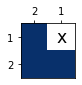

error_count:0


In [9]:
for row in range(board2x2.height):
    for col in range(board2x2.width):
        value = BoardMark.BLACK if probs2x2[row, col] >= 0.5 else BoardMark.FILLER
        if game2x2.is_action_valid(row, col, value):
            board2x2.mark(row, col, value)
        else: 
            alt_value = BoardMark.FILLER if probs2x2[row, col] >= 0.5 else BoardMark.BLACK    
            board2x2.mark(row, col, alt_value)

game2x2.show_board()
print(f"error_count:{game2x2.errors}")

In [10]:
clues5x5s

{'rows': [1, 3, [1, 1], 3, 5], 'cols': [1, 4, [2, 2], 4, 1]}

In [12]:
# create the game engine
puzzle5x5s = Puzzle(clues5x5s)
game5x5s = GameEngine(puzzle5x5s, solution5x5s)
board5x5s = game5x5s.board

In [15]:
sum_row_0 = sum(puzzle5x5s.norm_clues['rows'][0])
sum_row_0

1

In [16]:
sum_row_2 = sum(puzzle5x5s.norm_clues['rows'][2])
sum_row_2

2

In [17]:
probs5x5s = np.full((board5x5s.height, board5x5s.width), -1, dtype=float)
for i_row in range(len(clues5x5s['rows'])):
    sum_row = sum(puzzle5x5s.norm_clues['rows'][i_row])
    for i_col in range(len(clues5x5s['cols'])):
        sum_col = sum(puzzle5x5s.norm_clues['cols'][i_col])
        probs5x5s[i_row, i_col] = (sum_row/board5x5s.width) * (sum_col/board5x5s.height)
        
probs5x5s

array([[0.04, 0.16, 0.16, 0.16, 0.04],
       [0.12, 0.48, 0.48, 0.48, 0.12],
       [0.08, 0.32, 0.32, 0.32, 0.08],
       [0.12, 0.48, 0.48, 0.48, 0.12],
       [0.2 , 0.8 , 0.8 , 0.8 , 0.2 ]])

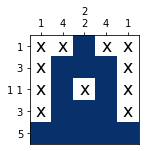

error_count:11


In [19]:
for row in range(board5x5s.height):
    for col in range(board5x5s.width):
        value = BoardMark.BLACK if probs5x5s[row, col] >= 0.5 else BoardMark.FILLER
        if game5x5s.is_action_valid(row, col, value):
            board5x5s.mark(row, col, value)
        else: 
            alt_value = BoardMark.FILLER if probs5x5s[row, col] >= 0.5 else BoardMark.BLACK    
            board5x5s.mark(row, col, alt_value)

game5x5s.show_board()
print(f"error_count:{game5x5s.errors}")

MC

In [21]:
import random

random.uniform(0,1)

0.3735395259734938

In [ ]:
p = 0.75
for i in range(10):
    value = BoardMark.BLACK if random.uniform(0,1)<=p else BoardMark.FILLER
    print(value)

[0, 0, 1, 1]


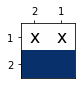

[1, 0, 1, 1]


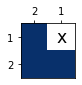

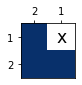

In [103]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

def mc_sampler():
    X = []
    for row in range(board2x2.height):
        for col in range(board2x2.width):
            is_black = np.random.normal(probs2x2[row, col], 0.1) >= 0.5 
            #is_black = random.uniform(probs2x2[row, col],1) >= 0.5 
            value = BoardMark.BLACK.value if is_black else BoardMark.FILLER.value
            X.append(value)
    return X

solved = False
sample = None
samples = []
while(not solved):
    sample =  mc_sampler()
    if not sample in samples:
        samples.append(sample)
        print(sample)
        board2x2.fill_all(sample)
        game2x2.show_board()
        solved = game2x2.is_expected_solution(sample)

board2x2.fill_all(sample)
game2x2.show_board()

In [93]:
np.random.normal(0.8,0.1)

0.6924447838722496

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]


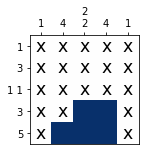

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]


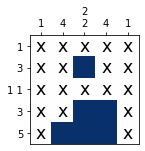

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]


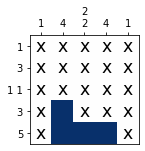

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


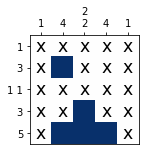

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]


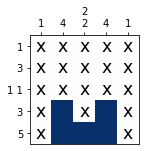

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]


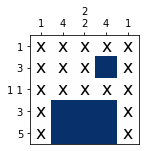

[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]


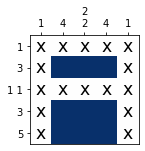

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]


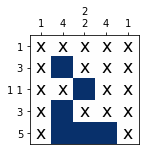

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]


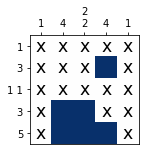

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]


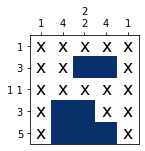

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]


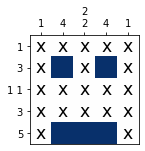

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]


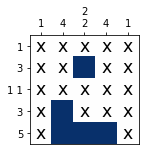

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]


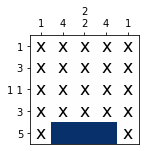

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]


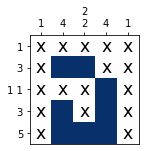

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]


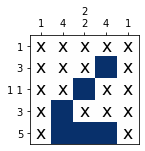

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


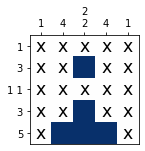

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]


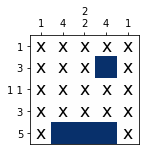

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


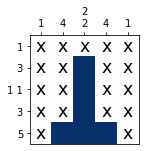

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]


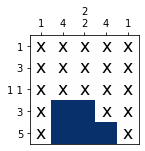

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]


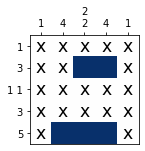

[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]


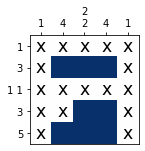

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]


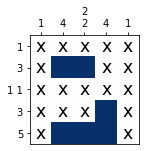

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]


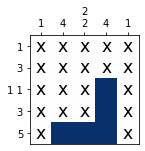

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]


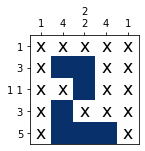

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]


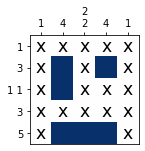

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]


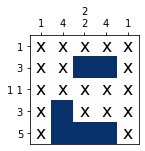

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]


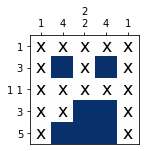

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]


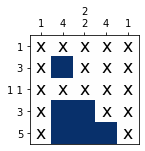

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


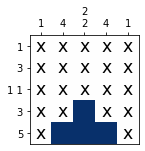

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]


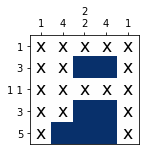

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]


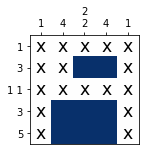

[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]


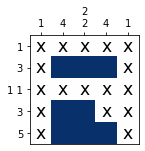

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]


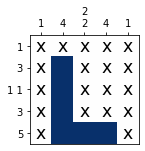

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]


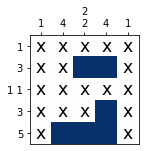

In [86]:
# create the game engine
puzzle5x5s = Puzzle(clues5x5s)
game5x5s = GameEngine(puzzle5x5s, solution5x5s)
board5x5s = game5x5s.board

def mc_sampler():
    X = []
    for row in range(board5x5s.height):
        for col in range(board5x5s.width):
            is_black = np.random.normal(probs5x5s[row, col], 0.1) >= 0.5 
            #is_black = random.uniform(probs5x5s[row, col],1) >= 0.5 
            value = BoardMark.BLACK.value if is_black else BoardMark.FILLER.value
            X.append(value)
    return X

solved = False
sample = None
samples = []
i = 0
while(not solved and i<50):
    sample =  mc_sampler()
    if not sample in samples:
        samples.append(sample)
        print(sample)
        board5x5s.fill_all(sample)
        game5x5s.show_board()
        solved = game5x5s.is_expected_solution(sample)
    i += 1



# 7. Mathematic approach

simpy, sympy, cypy

# 8. Optimization by Genetic Algorithm

"genetic algorithm (GA) is a metaheuristic inspired by the process of natural selection that belongs to the larger class of evolutionary algorithms (EA). Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems by relying on biologically inspired operators such as mutation, crossover and selection" - Wikipedia

TODO how could it work here, explain a little bit the selection process

https://pypi.org/project/geneticalgorithm/
    
geneticalgorithm is a Python library distributed on Pypi for implementing standard and elitist genetic-algorithm (GA). This package solves continuous, combinatorial and mixed optimization problems with continuous, discrete, and mixed variables. It provides an easy implementation of genetic-algorithm (GA) in Python.

We will use geneticalgorithm for this demonstration because it is more simple and fit this case. Plase not that there is also PyGAD

https://pygad.readthedocs.io/en/latest/

PyGAD is an open-source Python library for building the genetic algorithm and optimizing machine learning algorithms. It works with Keras and PyTorch.

PyGAD supports different types of crossover, mutation, and parent selection operators. PyGAD allows different types of problems to be optimized using the genetic algorithm by customizing the fitness function.

## 8.1. Example

In [ ]:
! pip install geneticalgorithm

Assume we want to find a set of X=(x1,x2,x3) that minimizes function f(X)=x1+x2+x3 where X can be any integer number in [0,10].

In [ ]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    return np.sum(X)

varbound=np.array([[0,10]]*3)

model=ga(function=f,dimension=3,variable_type='int',variable_boundaries=varbound)

model.run()


In a nonogram 2x2 we want to find a set of X=(x1,x2,x3,x4) that minimizes an error function f(X)=x1+x2+x3 where X can be any integer number in [0,1].
The error function compute the deviation from the clues.

## 8.2. Proof of concept on 2x2

In [ ]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)
board2x2 = game2x2.board

to make it simple we will use the overall sum. The real function should compare col/row sums on X with clues

In [ ]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    # assume we know a solution to avoid ilplementing the sums
    # minimizing the error
    game2x2.is_expected_solution(X.tolist())
    return game2x2.errors

varbound=np.array([[0,1]]*puzzle2x2.cells_count)

model=ga(function=f, 
         dimension=puzzle2x2.cells_count, 
         variable_type='int',
         variable_boundaries=varbound)

model.run()

In [ ]:
solution = model.output_dict
solution

Please note that it found any array with three 1 and one 0. This is caused by the error function being too loose.
In the dict
- variable contains the optimized output
- function is the residual error after the model ran

In [ ]:
board2x2.fill_all(solution['variable'].tolist())
game2x2.show_board()

Test 5x5

In [87]:
# create the game engine
puzzle5x5s = Puzzle(clues5x5s)
game5x5s = GameEngine(puzzle5x5s, solution5x5s)
board5x5s = game5x5s.board

 The best solution found:                                                                           
 [0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1.]

 Objective function:
 0.0


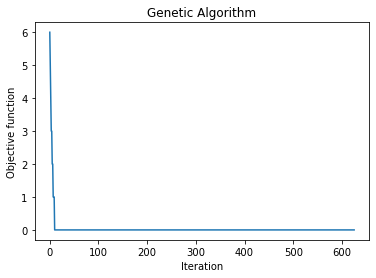

In [89]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    # assume we know a solution to avoid ilplementing the sums
    # minimizing the error
    game5x5s.is_expected_solution(X.tolist())
    return game5x5s.errors

varbound=np.array([[0,1]]*puzzle5x5s.cells_count)

model=ga(function=f, 
         dimension=puzzle5x5s.cells_count, 
         variable_type='int',
         variable_boundaries=varbound)

model.run()

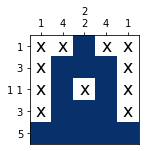

In [90]:
solution = model.output_dict
board5x5s.fill_all(solution['variable'].tolist())
game5x5s.show_board()

## 8.3. Wrap up

What works:
- it is simple to design and implement
- pretty easy to use
- it works on a numpy which will make it easy to compute rules

Limitation:
- May be overkill for this simple problem


This prrof of concept is 

Computations in the error function may use reshape and np.sum to cimpute sums on X. And then compare each sums to each clue in order to compute the abs error sum element by element. 

In [ ]:
states = np.array([1, 0, 1, 1]).reshape(2,2)
states

In [ ]:
states.sum(axis=0) # O col

In [ ]:
states.sum(axis=1) # 1 col

- Ideation: 10mn
- Design: 10mn - feature out that X is a numpty arry
- Implementation: 20mn  - error function (but only sum up, not real rules, estimated to 1h)

# 9. Machine Learning

TODO

# 10. Wrap up

This quick exploration of ways of solving this problem show that we need some additional components :
- a game engine which provides the try-and-error validation and the board validation 
- some operation thate were identified in episode 01: is the board completed, is the board valid
- a puzzle class with some operations to transform the clues and compute black count and cels count
- try-and-error and learning process will require something in between not done and done in order to improve on rewards:   number of cells completed/undefined, number of errors, number of valid celss
